<a href="https://colab.research.google.com/github/ND-CSE-30151/spring-2024/blob/main/notes/14-dpdas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 14: Deterministic parsing (optional)

In [3]:
#@title Setup
!pip install -qqq tock
from tock import *
!test -x /content/theory || git clone --quiet https://github.com/ND-CSE-30151/spring-2024 /content/theory
%cd -q /content/theory/notes

## Deterministic PDAs

<div class="alert alert-info">
    <p><b>Read</b> pages 130-131.</p>
</div>
    
A *deterministic PDA* is a PDA that always knows what to do, given the next input symbol and top stack symbol. If $u$ and $v$ are strings, let's write $u \bowtie v$ iff either $u$ is a prefix of $v$ or $v$ is a prefix of $u$. (Remember that $\varepsilon$ is a prefix of every string.) Then, there cannot be two transitions from the same state,
\begin{align*}
q &\xrightarrow{a, x \rightarrow y} r \\
q &\xrightarrow{a', x' \rightarrow y'} r'
\end{align*}
such that $a \bowtie a'$ and $x \bowtie x'$.

## LL parsing

Deterministic PDAs are appealing because they are much easier to implement. However, the CFG to PDA conversion in the book outputs a deterministic PDA only for the most uninteresting CFGs.

For example, the following grammar generates the language $\{\texttt{a}^i \texttt{b}^j \texttt{c}^i \mid i, j \geq 0\}$, which you could easily write a deterministic PDA for:

\begin{align*}
S &\rightarrow \texttt{a} S \texttt{c} \\
S &\rightarrow T \\
T &\rightarrow \texttt{b} T \\
T &\rightarrow \varepsilon
\end{align*}

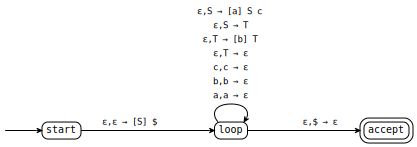

In [4]:
g = Grammar.from_lines(["S -> a S c",
                        "S -> T",
                        "T -> b T",
                        "T -> &"])
p1 = from_grammar(g)
to_graph(p1)

In [5]:
p1.is_deterministic()

False

There is nondeterminism in state `loop`, when the top stack symbol is either $S$ or $T$. Each of these nonterminals has two rules it can be rewritten with, and the PDA doesn't know which one to use.

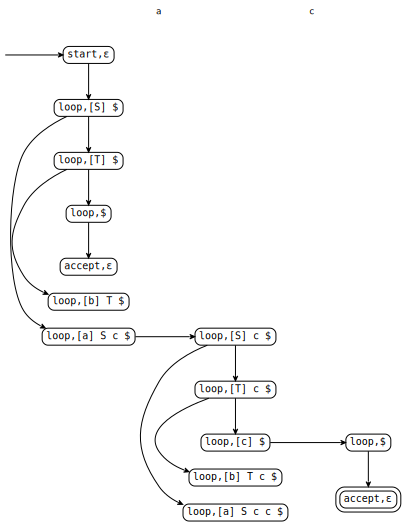

In [6]:
run(p1, 'a c', show_stack=10)

Do you see the places where there are two branches, but one of them eventually reaches a dead end? You can figure out intuitively how to avoid the wrong branch:

- If the top stack symbol is $S$:
    - If the next input symbol is $\texttt{a}$, use the first rule ($S \rightarrow \texttt{a} S \texttt{c}$).
    - Else, use the second rule ($S \rightarrow T$).
- If the top stack symbol is $T$:
    - If the next symbol is $\texttt{b}$, use the third rule ($T \rightarrow \texttt{b} T$).
    - Else, use the fourth rule ($T \rightarrow \varepsilon$).
    
Below, we'll show how to modify the CFG to PDA conversion to output a deterministic PDA that is able to _look ahead_ one symbol to capture the above intuition.

### The endmarker

When the PDA is at the end of the string, we want it to be able to look ahead and see that there are no more input symbols. So let's append an _endmarker_ $\dashv$ to end of the input string. We continue to write $\Sigma$ for the original alphabet that does not contain $\dashv$.

Accordingly, we modify our grammar by creating a new start nonterminal, $S'$, and adding a rule

$$ S' \rightarrow S\dashv $$

### Basic idea

Given a top stack symbol $A$ and a look-ahead input symbol $c$, we want to automatically figure out which rule $A \rightarrow \beta$ to use. We will use the following two filters:

- If $\beta$ can be rewritten to a string that starts with $c$, then $A \rightarrow \beta$ is possible.
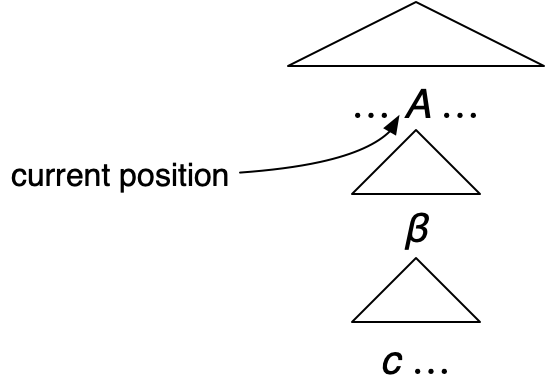

- If $\beta$ can be rewritten to $\varepsilon$ and it's possible for $c$ to come after $A$, then $A \rightarrow \beta$ is possible.
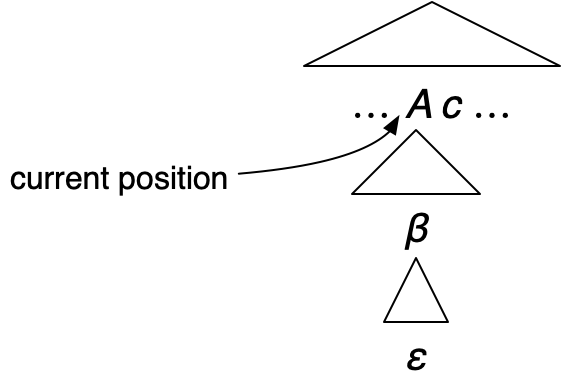

After applying these filters, we want at most one rule to be possible at a time.

We implement this logic by precomputing three tables, defined below.

### The $\text{Nullable}$ table

Define a _rhs suffix_ of $G$ to be a suffix of the right-hand side of a rule of $G$. The rhs suffixes of our example grammar are: $\varepsilon, \texttt{c}, S\texttt{c}, \texttt{a}S\texttt{c}, T, \texttt{b}T$.

Define a table $\text{Nullable}(\alpha)$, where $\alpha$ is a nonterminal symbol or a rhs suffix, that says whether it's possible to rewrite $\alpha$ to the empty string (that is, $\alpha \Rightarrow^\ast \varepsilon$).

1. For all $\alpha$, $\text{Nullable}(\alpha) \leftarrow \text{False}$.
2. $\text{Nullable}(\epsilon) \leftarrow \text{True}$.
3. Repeat until $\text{Nullable}$ does not change:
    1. For each rule $A \rightarrow \beta$:
        1. $n \leftarrow |\beta|$
        2. For $i \leftarrow n, \ldots, 1$:
            1. If $\text{Nullable}(\beta_{i+1} \cdots \beta_n)$ and $\text{Nullable}(\beta_i)$, then $\text{Nullable}(\beta_i \cdots \beta_n) \leftarrow \text{True}$
        3. If $\text{Nullable}(\beta)$, then $\text{Nullable}(A) \leftarrow \text{True}$.
        
Here's our example grammar again:

In [7]:
g

And here are the nullable nonterminals and rhs suffixes:

In [8]:
for alpha in g.compute_nullable(): print(alpha)

S
ε
T


### The $\text{First}$ table

Define a table $\text{First}(\alpha)$, where $\alpha$ is a terminal or nonterminal symbol
or a rhs suffix, that says what terminals $\alpha$ can start with (after rewriting). That is,
$$\text{First}(\alpha) = \{b \mid \text{$\alpha \Rightarrow^\ast b\gamma$ for some $\gamma$}\}$$

1. For all $\alpha$, $\text{First}(\alpha) = \emptyset$.
1. For all terminals $a$, $\text{First}(a) = \{ a \}$.
2. Repeat until $\text{First}$ does not change:
    1. For each rule $A \rightarrow \beta$:
        1. $n \leftarrow |\beta|$
        2. For $i \leftarrow n, \ldots, 1$:
            1. $\text{First}(\beta_i \cdots \beta_n) \leftarrow \text{First}(\beta_i \cdots \beta_n) \cup \text{First}(\beta_{i})$.
            1. If $\text{Nullable}(\beta_i)$, then $\text{First}(\beta_i \cdots \beta_n) \leftarrow \text{First}(\beta_i \cdots \beta_n) \cup \text{First}(\beta_{i+1} \cdots \beta_n)$.
        3. $\text{First}(A) \leftarrow \text{First}(A) \cup \text{First}(\beta)$.

In our example grammar, we have

In [9]:
g

In [10]:
for alpha, first_alpha in g.compute_first().items():
    print(f'{alpha}\t{syntax.Set(first_alpha)}')

ε	∅
S	{a,b}
a	{a}
a S c	{a}
S c	{a,b,c}
c	{c}
T	{b}
b	{b}
b T	{b}


### The $\text{Follow}$ function

Define a table $\text{Follow}(A)$ that says, for each nonterminal $A$, what terminals can come after it. That is, $$\text{Follow}(A) = \{ b \mid \text{$S \Rightarrow^\ast \gamma A b \delta$ for some $\gamma, \delta$} \}$$

1. For all $A$, $\text{Follow}(A) = \emptyset$.
2. Repeat until $\text{Follow}$ does not change:
    1. For each rule $A \rightarrow \beta$:
        1. $n \leftarrow |\beta|$
        1. For $i \leftarrow 1, \ldots, n$ such that $\beta_i$ is a nonterminal $B$:
            1. $\text{Follow}(B) \leftarrow \text{Follow}(B) \cup \text{First}(\beta_{i+1}\cdots \beta_n)$
            2. If $\text{Nullable}(\beta_{i+1} \cdots \beta_n)$, then $\text{Follow}(B) \leftarrow \text{Follow}(B) \cup \text{Follow}(A)$.
            
In our example grammar, we have

In [11]:
g

In [12]:
for alpha, follow_alpha in g.compute_follow().items():
    print(f'{alpha}\t{syntax.Set(follow_alpha)}')

T	{c,⊣}
S	{c,⊣}


### Recursive-descent parsing

We can now use these tables to implement a _recursive-descent_ parser, which has a function for each nonterminal symbol. The function for nonterminal $A$ is called on an input string $w$ and a position $i$ and has to return $j$ such that $A \Rightarrow^\ast w_i \cdots w_{j-1}$. To do this, the function must decide which rule to use, using the Nullable, First, and Follow tables. For our example grammar, the parser would look like:

In [13]:
class ParseError(Exception): pass

def parse(w):
    try:
        i = parseS(w, 0)
    except ParseError:
        return False
    if i == len(w):
        return True
    else:
        return False

def parseS(w, i):
    # S -> aSc
    if i < len(w) and w[i] in {"a"}: # First(aSc) = {a}
        i = i + 1
        i = parseS(w, i)
        if w[i] != "c": raise ParseError()
        i = i + 1
        return i
    # S -> T
    elif (i < len(w) and w[i] in {"b"} # First(T) = {b}
          or
          i == len(w) or w[i] in {"c"}): # Nullable(T) and Follow(S) = {⊣, c}
        return parseT(w, i)
    else:
        raise ParseError()

def parseT(w, i):
    # T -> bT
    if i < len(w) and w[i] in {"b"}: # First(bT) = {b}
        i = i + 1
        return parseT(w, i)
    # T -> ε
    elif i == len(w) or w[i] in {"c"}: # Nullable(ε) and Follow(T) = {⊣, c}
        return i
    else:
        raise ParseError()

In [14]:
parse('a a b c c'.split())

True

In [15]:
parse('a a b c c c'.split())

False

### Conversion to DPDA

We can also use the Nullable, First, and Follow tables to build a DPDA. To do this, we first modify the conversion from a CFG to a PDA to use a one-symbol lookahead. The states of the PDA are the start state $s$, $q$, a state $q_a$ for each $a \in \Sigma$, and an accept state $f$.

1. A transition from $s$ to $q$ that pushes $S\$$.
2. A transition from $q$ to $q_a$ that reads $a$ for all $a \in \Sigma \cup \{\dashv\}$.
3. A transition from $q_a$ to $q$ that pops $a$, for all $a \in \Sigma$.
4. For each rule $A \rightarrow \beta$ and each $c \in \Sigma$, a transition from $q_c$ to itself that pops $A$ and pushes $\beta$.
5. A transition from $q$ to $f$ that pops $\$$.

The PDA looks like this (using the shorthand on page 119):

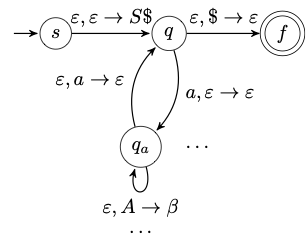

where state $q_a$ is replicated for every possible terminal symbol, and the self-loop on state $q_a$ is replicated for all rules.

For our example grammar, this PDA looks like this:

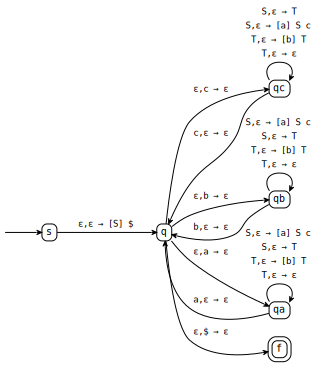

In [16]:
p2 = read_csv('llpda.csv')
p2

In [17]:
p2.is_deterministic()

False

This PDA is similar to the one in the proof of Lemma 2.21, but it has states $q_a$ that can apply rules with the knowledge that the next input symbol is $a$.

So, we can restrict the application of rules only to those that are allowed by Nullable, First, and Follow:

4. For each rule $A \rightarrow \beta$ and for each $c \in \Sigma$ such that $c \in \text{First}(\beta)$ or ($\text{Nullable}(\beta)$ and $c \in \text{Follow}(A)$), a transition from $q_c$ to itself that pops $A$ and pushes $\beta$.

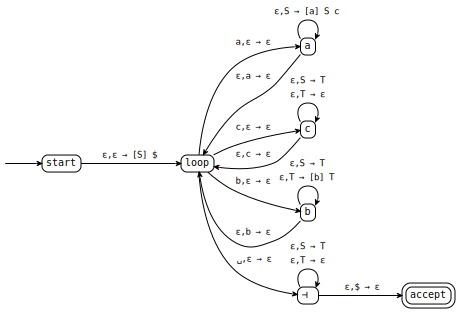

In [18]:
p3 = from_grammar(g, mode='ll1')
p3

(Tock's implementation of LL(1) uses a blank (_) as the endmarker.)

In [19]:
p3.is_deterministic()

True

Now the PDA is deterministic, which is what we wanted. Note that it was not *guaranteed* to be deterministic; we just got lucky. If it is deterministic, we say that the original grammar is $LL(1)$.

### Making grammars $LL(1)$

So, if grammars are not guaranteed to be $LL(1)$, how do we design our grammars so that they are? We show two strategies that can sometimes (but not always) help.

**Merge common prefixes.** Consider this very simple grammar:

\begin{align*}
S &\rightarrow \texttt{a b} \\
S &\rightarrow \texttt{a c}
\end{align*}

It's not $LL(1)$ because $\texttt{a}$ belongs to both $\text{First}(\texttt{a b})$ and $\text{First}(\texttt{a c})$. The solution is to create a new nonterminal for the non-shared part, like this:

\begin{align*}
S &\rightarrow \texttt{a} S' \\
S' &\rightarrow \texttt{b} \\
S' &\rightarrow \texttt{c}
\end{align*}

In general, if we have two rules
\begin{align*}
A &\rightarrow \beta\gamma \\
A &\rightarrow \beta\delta
\end{align*}
then $\text{First}(\beta\gamma)$ and $\text{First}(\beta\delta)$ wlil overlap, and the solution is to change this to
\begin{align*}
A &\rightarrow \beta A' \\
A' &\rightarrow \gamma \\
A' &\rightarrow \delta
\end{align*}

**Eliminate left recursion.** Consider this grammar:

\begin{align*}
S &\rightarrow S~\texttt{-}~T \\
S &\rightarrow T \\
T &\rightarrow \texttt{1}
\end{align*}

The first rule is called _left-recursive_ because the first symbol on the right-hand side is the same as the left-hand side. In such cases there will always be an overlap between the left-recursive rule's and the "base case" rule's right-hand side. The usual fix is:

\begin{align*}
S &\rightarrow T S' \\
S' &\rightarrow \texttt{-}~T S' \\
S' &\rightarrow \varepsilon \\
T &\rightarrow \texttt{1}
\end{align*}

But be careful, because it seems we just changed - (minus) from left-associative to right-associative. In a recursive-descent parser, we can get the associativity correct like this:

In [20]:
def parse(w):
    val, i = parseS(w, 0)
    if i == len(w):
        return val
    else:
        raise ParseError()

def parseS(w, i):
    # S -> T S'
    val, i = parseT(w, i)
    val, i = parseS1(w, i, val)
    return val, i

def parseS1(w, i, val):
    # S' -> - T S'
    if i < len(w) and w[i] in {"-"}: # First(+ T S')
        i = i + 1
        val2, i = parseT(w, i)
        val, i = parseS1(w, i, val-val2)
        return val, i
    elif i == len(w): # Follow(S')
        return val, i
    else:
        raise ParseError()

def parseT(w, i):
    # T -> a
    if i < len(w) and w[i] in {"1"}: # First(1)
        i = i + 1
        return 1, i
    else:
        raise ParseError()

In [21]:
parse('1 - 1 - 1'.split())

-1

## LR parsing

There's another parsing strategy that the book doesn't mention at this point. It's called *bottom-up*, *shift-reduce*, or maybe sometimes "nondeterministic LR" parsing. It's the basis for most parsing algorithms that are used in compilers.

The idea is again pretty simple -- it's like top-down parsing in reverse. The stack is initialized to $\mathtt{\$}$. At any point in time, we can do two operations.

In a *shift*, we read in one input symbol and push it onto the stack.

In a *reduce*, we check to see if the prefix (top symbols) of the stack match a right-hand-side of a rule (in reverse order), and if so, we can pop those symbols and replace them with the left-hand-side of the rule.

This algorithm is again nondeterministic: it's always possible to do a shift unless we're at the end of the string, and it may be possible to do several different reduces.

If we reach the end of the input and the stack has just $S\mathtt{\$}$, then we accept.

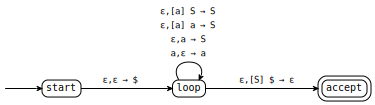

In [22]:
g = Grammar.from_lines([
    "S -> S a",
    "S -> a a",
    "S -> a",
])

p = from_grammar(g, mode='bottomup')
p

In [23]:
p.is_deterministic()

False

In [24]:
run(p, 'a a',show_stack=4).shortest_path()

start,[a] a,ε
loop,[a] a,$
loop,a,[a] $
loop,ε,[a] a $
loop,ε,[S] $
accept,ε,ε


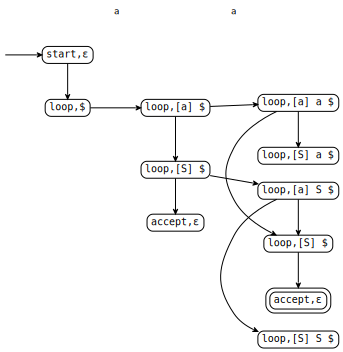

In [25]:
run(p, 'a a',show_stack=4)

Even in this very simple example, we can see several examples of conflicts:
- From the configuration `loop,[a] $`, there is a shift transition to `loop,[a] a $` and a reduce transition to `loop,[S] $` (using rule `S -> a`).
-  From the configuration `loop,[a] a $`, there is a reduce transition to both `loop,[S] a $` (using rule `S -> a`) and `loop,[S] $` (using rule `S -> a a`).
-  From the configuration `loop,[S] $`, there is a shift transition to `loop,[a] S $` and to `accept,ε`.

This notebook is already quite long, so if you are still reading, I'll now refer you to the book to learn about how to construct deterministic shift-reduce parsers.

<p class="alert alert-info"><b>Read</b> Section 2.4.</p>

If you want to experiment, you can use Tock to construct LR(0) automata and LR(0) parsers:

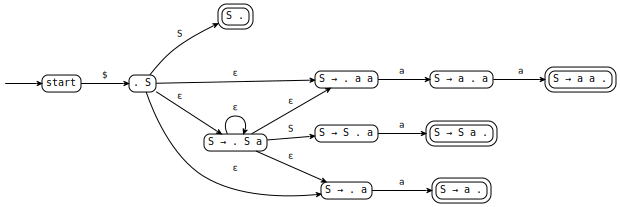

In [26]:
grammars.lr_automaton(g, 0)

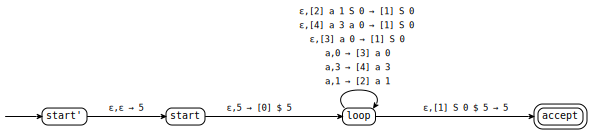

In [27]:
from_grammar(g, mode='lr0')